# Exp 1 — Ring Line World with Rewards + Energy (LLM as Policy)

Goal:
- Build the *minimal* simulation environment on a **ring line** (periodic boundary).
- Add **rewards** at locations (collected when landed on).
- Add **energy** (movement costs energy; if 0 → no movement).
- Use an **LLM policy** (Ollama) to choose actions.
- Log trajectories + compute basic metrics for **behavioral strategy inference** (no self-report).


## Key Concept: LLM as a Policy

A *policy* is a function:

**observation → action**

Here, the LLM is the policy:
1. We build a structured observation (JSON).
2. We send it to the LLM with strict instructions.
3. The LLM outputs a structured action (JSON).
4. We validate and apply it to update the world.

Important:
- The LLM never changes the world directly.
- The simulator applies world rules deterministically.


In [1]:
import json
import time
import math
import random
from pathlib import Path
from typing import Dict, Literal, Optional, Tuple

import requests
from pydantic import BaseModel, Field, ValidationError,conint, model_validator


## 1) Experiment Configuration

We keep all experiment constants in one place:
- ring length `L`
- horizon `T`
- energy + movement cost
- reward map
- partial observability radius
- Ollama model + decoding settings
- output directory for logs


In [ ]:
# ---- World parameters ----
L = 20                 # ring positions: 0..19
T = 500                 # max steps
START_X = 0
START_ENERGY = 10
MOVE_COST = 1
ALPHA = 0.5                 # reward -> energy conversion
MAX_ENERGY = 50             # hard cap (prevents runaway)
MAX_STEPS_PER_ACTION = 10   # cap action space (LLM chooses 1..10)
MOVE_COST_PER_STEP = 1      # energy cost per step


# reward locations: position -> value
REWARDS_INIT = {2: 5.0, 9: 10.0, 14: 7.0}

# partial observability: rewards visible within VIS_RADIUS ring-distance
VIS_RADIUS = 3

# ---- LLM (Ollama OpenAI-compatible) ----
OLLAMA_BASE_URL = "http://localhost:11434/v1"
OLLAMA_MODEL = "mistral"
TEMPERATURE = 0.2
MAX_TOKENS = 120

# ---- Output ----
RUN_DIR = Path("runs/exp_1_ring_line_rewards") / time.strftime("%Y%m%d-%H%M%S")
RUN_DIR.mkdir(parents=True, exist_ok=True)
LOG_PATH = RUN_DIR / "trajectory.jsonl"
METRICS_PATH = RUN_DIR / "metrics.json"
CONFIG_PATH = RUN_DIR / "config.json"

print("Run dir:", RUN_DIR)


Run dir: runs/exp_1_ring_line_rewards/20251226-151036


## 2) Schemas: Observation and Action

Why schemas?
- Make the simulator–policy interface explicit and stable.
- Validate LLM outputs safely.
- Make later FastAPI integration trivial.

Observation includes:
- time step `t`
- ring length `L`
- agent state (`x`, `energy`)
- visible rewards (partial observability)

Action is minimal:
- one field: `type` ∈ {LEFT, RIGHT, WAIT}


In [23]:
ActionType = Literal["MOVE", "WAIT"]
Dir = Literal["LEFT", "RIGHT"]

class Observation(BaseModel):
    t: int
    L: int
    x: int
    energy: int
    visible_rewards: Dict[int, float] = Field(default_factory=dict)

class Action(BaseModel):
    type: ActionType
    dir: Optional[Dir] = None
    steps: Optional[conint(ge=1)] = None  # we'll cap in validation

    @model_validator(mode="after")
    def _validate_shape(self):
        if self.type == "WAIT":
            return self  # dir/steps can be None
        # MOVE requires dir and steps
        if self.dir not in ("LEFT", "RIGHT") or self.steps is None:
            raise ValueError("MOVE requires dir in {LEFT,RIGHT} and steps >= 1")
        # enforce a hard cap so the LLM can't request huge jumps
        if self.steps > MAX_STEPS_PER_ACTION:
            raise ValueError(f"steps must be <= {MAX_STEPS_PER_ACTION}")
        return self

## 3) World Mechanics (Ring + Energy + Reward)

Ring boundary means:
- RIGHT from 19 wraps to 0
- LEFT from 0 wraps to 19

Energy rules:
- LEFT/RIGHT cost MOVE_COST energy
- WAIT costs 0
- if energy is 0, movement is not possible (forced WAIT behavior)

Reward rules:
- if agent lands on a reward position, it collects that value
- for simplicity, the reward is removed after collection


In [24]:
def ring_dist(a: int, b: int, L: int) -> int:
    """Shortest distance between positions a and b on a ring of length L."""
    d = abs(a - b)
    return min(d, L - d)

def observe(t: int, x: int, energy: int, rewards: Dict[int, float], L: int, vis_r: int) -> Observation:
    """Build the agent's partial observation: only rewards within visibility radius."""
    visible = {pos: val for pos, val in rewards.items() if ring_dist(x, pos, L) <= vis_r}
    return Observation(t=t, L=L, x=x, energy=energy, visible_rewards=visible)


In [25]:
def apply_action(x: int, energy: int, action: Action, L: int) -> Tuple[int, int, int]:
    """
    Apply action under energy constraints on a ring.
    Returns (new_x, new_energy, steps_executed).
    """
    if energy <= 0:
        return x, 0, 0

    if action.type == "WAIT":
        return x, energy, 0

    # MOVE
    requested_steps = action.steps  # validated to exist

    # clip-to-energy: do as many steps as affordable
    affordable_steps = min(requested_steps, energy // MOVE_COST_PER_STEP)

    if affordable_steps <= 0:
        return x, energy, 0  # can't afford even 1 step

    dx = -1 if action.dir == "LEFT" else 1
    new_x = (x + dx * affordable_steps) % L
    new_energy = energy - affordable_steps * MOVE_COST_PER_STEP
    return new_x, new_energy, affordable_steps


def collect_reward_and_energy(x: int, rewards: Dict[int, float]) -> Tuple[float, int]:
    """
    If reward exists at x:
    - collect reward value
    - gain energy proportional to reward: floor(ALPHA * reward)
    - remove reward
    """
    if x not in rewards:
        return 0.0, 0

    val = rewards[x]
    del rewards[x]

    energy_gain = int(math.floor(ALPHA * val))
    return val, energy_gain

## 4) Logging (JSON Lines)

We log *one JSON object per step* (JSONL) so we can:
- reconstruct the trajectory
- compute behavioral metrics later
- compare controlled conditions across runs

We'll log:
- observation
- raw LLM output
- parsed action
- state transition + reward gained
- remaining rewards


In [26]:
def log_event(path: Path, event: dict) -> None:
    with path.open("a", encoding="utf-8") as f:
        f.write(json.dumps(event, ensure_ascii=False) + "\n")


## 5) LLM Policy

The LLM policy is a black-box function:
- input: Observation (serialized into JSON text)
- output: Action JSON

We enforce structure by:
- strict system message: "output ONLY JSON"
- validating output with Pydantic
- fallback to WAIT on invalid outputs

Note:
- This is *not training*. The model is fixed.
- Strategy inference comes from analyzing trajectories + metrics.



In [27]:
def llm_call(system: str, user: str) -> str:
    """
    Call Ollama's OpenAI-compatible endpoint: /v1/chat/completions
    Returns the assistant message content as a string.
    """
    url = f"{OLLAMA_BASE_URL}/chat/completions"
    payload = {
        "model": OLLAMA_MODEL,
        "messages": [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ],
        "temperature": TEMPERATURE,
        "max_tokens": MAX_TOKENS,
    }
    r = requests.post(url, json=payload, timeout=60)
    r.raise_for_status()
    return r.json()["choices"][0]["message"]["content"]


In [28]:
def llm_policy(obs: Observation) -> Tuple[Action, str]:
    """
    LLM policy:
    - Build prompt
    - Call LLM
    - Parse JSON -> Action
    - If invalid, fallback WAIT
    Returns (Action, raw_llm_output)
    """
    system = (
    "You are an agent on a ring line. Output ONLY JSON.\n"
    "Valid outputs:\n"
    "1) {\"type\":\"WAIT\"}\n"
    "2) {\"type\":\"MOVE\",\"dir\":\"LEFT\"|\"RIGHT\",\"steps\":1..%d}\n"
    "No extra keys. No extra text."
    ) % MAX_STEPS_PER_ACTION


    user = json.dumps({
        "observation": obs.model_dump(),
        "allowed_actions": {
            "WAIT": {},
            "MOVE": {
                "dir": ["LEFT", "RIGHT"],
                "steps": {"min": 1, "max": MAX_STEPS_PER_ACTION}
            }
        },
        "output_format_examples": [
            {"type": "WAIT"},
            {"type": "MOVE", "dir": "RIGHT", "steps": 3}
        ],
        "notes": [
            "Output JSON only.",
            "Do not add extra keys.",
            "If energy is low, choose smaller steps or WAIT."
        ]
    })


    raw = llm_call(system, user).strip()

    try:
        action = Action.model_validate_json(raw)
        return action, raw
    except ValidationError:
        # If the LLM output isn't valid JSON matching schema, we apply a safe fallback.
        return Action(type="WAIT"), raw


## 6) Behavioral Metrics (Strategy Inference)

We infer "strategy" from behavior, not explanations.

Minimal metrics:
- total reward collected
- coverage (unique positions visited)
- steps to first reward (if any)
- action distribution conditioned on energy (high/mid/low)

These already tell you:
- exploration vs exploitation
- energy-aware behavior (WAIT more when low energy?)
- stability vs dithering


In [29]:
def energy_bin(e: int) -> str:
    if e >= 10: return "high"
    if e >= 3:  return "mid"
    return "low"

def run(seed: int = 0) -> dict:
    rng = random.Random(seed)  # reserved for later (if you randomize world)

    x = START_X
    energy = START_ENERGY
    rewards = dict(REWARDS_INIT)

    visited = {x}
    total_reward = 0.0
    first_reward_t: Optional[int] = None

    action_counts_by_energy = {
        "high": {"MOVE": 0, "WAIT": 0},
        "mid":  {"MOVE": 0, "WAIT": 0},
        "low":  {"MOVE": 0, "WAIT": 0},
    }
    move_dir_counts_by_energy = {
        "high": {"LEFT": 0, "RIGHT": 0},
        "mid":  {"LEFT": 0, "RIGHT": 0},
        "low":  {"LEFT": 0, "RIGHT": 0},
    }


    # Save resolved config for reproducibility
    CONFIG_PATH.write_text(json.dumps({
        "L": L, "T": T,
        "START_X": START_X, "START_ENERGY": START_ENERGY, "MOVE_COST": MOVE_COST,
        "REWARDS_INIT": REWARDS_INIT, "VIS_RADIUS": VIS_RADIUS,
        "OLLAMA_MODEL": OLLAMA_MODEL, "TEMPERATURE": TEMPERATURE, "MAX_TOKENS": MAX_TOKENS,
        "seed": seed,
    }, indent=2), encoding="utf-8")

    for t in range(T):
        obs = observe(t, x, energy, rewards, L, VIS_RADIUS)

        action, raw_output = llm_policy(obs)
        bin_name = energy_bin(energy)

        # MOVE vs WAIT
        action_counts_by_energy[bin_name][action.type] += 1

        # LEFT vs RIGHT (only if MOVE)
        if action.type == "MOVE":
            move_dir_counts_by_energy[bin_name][action.dir] += 1


        # Track action distribution by energy BEFORE applying the action
        action_counts_by_energy[energy_bin(energy)][action.type] += 1

        # Apply dynamics
        x2, energy2, steps_executed = apply_action(x, energy, action, L)
        gained, energy_gain = collect_reward_and_energy(x2, rewards)
        energy2 = min(MAX_ENERGY, energy2 + energy_gain)


        if gained > 0 and first_reward_t is None:
            first_reward_t = t

        visited.add(x2)
        total_reward += gained

        # Log this step
        log_event(LOG_PATH, {
            "t": t,
            "obs": obs.model_dump(),
            "raw_llm_output": raw_output,
            "action": action.model_dump(),
            "x_before": x,
            "energy_before": energy,
            "x_after": x2,
            "energy_after": energy2,
            "reward_gained": gained,
            "reward_total_so_far": total_reward,
            "rewards_remaining": dict(rewards),
            "steps_executed": steps_executed,
            "energy_gained_from_reward": energy_gain,
        })

        # Update state
        x, energy = x2, energy2

        # Optional early stop if energy is depleted
        if energy <= 0:
            break

    metrics = {
        "steps_run": t + 1,
        "total_reward": total_reward,
        "coverage_unique_positions": len(visited),
        "first_reward_step": first_reward_t,
        "action_counts_by_energy_bin": action_counts_by_energy,
        "move_dir_counts_by_energy_bin": move_dir_counts_by_energy,
        "end_state": 
            {"x": x, 
             "energy": energy, 
             "rewards_remaining": rewards
            },
    }

    METRICS_PATH.write_text(json.dumps(metrics, indent=2), encoding="utf-8")
    return metrics


In [30]:
metrics = run(seed=0)
print("Run dir:", RUN_DIR)
print(json.dumps(metrics, indent=2))


Run dir: runs/exp_1_ring_line_rewards/20251226-151036
{
  "steps_run": 17,
  "total_reward": 22.0,
  "coverage_unique_positions": 12,
  "first_reward_step": 0,
  "action_counts_by_energy_bin": {
    "high": {
      "MOVE": 20,
      "WAIT": 0
    },
    "mid": {
      "MOVE": 10,
      "WAIT": 0
    },
    "low": {
      "MOVE": 4,
      "WAIT": 0
    }
  },
  "move_dir_counts_by_energy_bin": {
    "high": {
      "LEFT": 0,
      "RIGHT": 10
    },
    "mid": {
      "LEFT": 0,
      "RIGHT": 5
    },
    "low": {
      "LEFT": 0,
      "RIGHT": 2
    }
  },
  "end_state": {
    "x": 17,
    "energy": 0,
    "rewards_remaining": {}
  }
}


## 7) Inspecting Results

Open these files:
- `trajectory.jsonl`: one record per step (great for debugging + later analysis)
- `metrics.json`: summary metrics for quick comparisons

First questions:
- Did total_reward increase?
- How quickly did it find the first reward?
- Does it WAIT more when energy is low?
- Does it explore (coverage), or just oscillate?


In [31]:
# Show last 5 steps from the JSONL log (quick sanity check)
lines = LOG_PATH.read_text(encoding="utf-8").strip().splitlines()
for row in lines[-5:]:
    print(row)


{"t": 12, "obs": {"t": 12, "L": 20, "x": 4, "energy": 5, "visible_rewards": {}}, "raw_llm_output": "{\"type\":\"MOVE\",\"dir\":\"RIGHT\",\"steps\":4}", "action": {"type": "MOVE", "dir": "RIGHT", "steps": 4}, "x_before": 4, "energy_before": 5, "x_after": 8, "energy_after": 1, "reward_gained": 0.0, "reward_total_so_far": 12.0, "rewards_remaining": {"9": 10.0}, "steps_executed": 4, "energy_gained_from_reward": 0}
{"t": 13, "obs": {"t": 13, "L": 20, "x": 8, "energy": 1, "visible_rewards": {"9": 10.0}}, "raw_llm_output": "{\"type\":\"MOVE\", \"dir\":\"RIGHT\", \"steps\":2}", "action": {"type": "MOVE", "dir": "RIGHT", "steps": 2}, "x_before": 8, "energy_before": 1, "x_after": 9, "energy_after": 8, "reward_gained": 10.0, "reward_total_so_far": 22.0, "rewards_remaining": {}, "steps_executed": 1, "energy_gained_from_reward": 8}
{"t": 14, "obs": {"t": 14, "L": 20, "x": 9, "energy": 8, "visible_rewards": {}}, "raw_llm_output": "{\"type\":\"MOVE\",\"dir\":\"RIGHT\",\"steps\":5}", "action": {"type"

### Plotting and Visualization

In [32]:
# Cell: imports + helpers (publication-grade defaults without forcing colors/styles)
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def set_pub_defaults():
    # Clean, readable defaults; no explicit colors/styles
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 0.8,
    })

def load_run(run_dir: str | Path):
    run_dir = Path(run_dir)
    metrics = json.loads((run_dir / "metrics.json").read_text(encoding="utf-8"))
    traj_path = run_dir / "trajectory.jsonl"

    rows = []
    with traj_path.open("r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))

    df = pd.DataFrame(rows)
    # Flatten useful columns from your schema
    df["t"] = df["t"]
    df["x"] = df["x_after"]
    df["energy"] = df["energy_after"]
    df["reward"] = df["reward_gained"]
    df["reward_cum"] = df["reward_total_so_far"]
    df["steps_executed"] = df["steps_executed"]
    df["energy_gain"] = df["energy_gained_from_reward"]

    # Action fields
    df["action_type"] = df["action"].apply(lambda d: d.get("type"))
    df["action_dir"] = df["action"].apply(lambda d: d.get("dir"))
    df["action_steps_req"] = df["action"].apply(lambda d: d.get("steps"))

    # Obs fields (note: visible_rewards keys are strings in your logs)
    df["obs_x"] = df["obs"].apply(lambda d: d.get("x"))
    df["obs_energy"] = df["obs"].apply(lambda d: d.get("energy"))
    df["n_visible_rewards"] = df["obs"].apply(lambda d: len(d.get("visible_rewards", {})))


    return metrics, df



In [33]:
# Cell: choose a run directory (paste the printed RUN_DIR from your sim output)
set_pub_defaults()
run_dir = RUN_DIR  # <-- change this

metrics, df = load_run(run_dir)

print("Loaded:", run_dir)
print("Steps:", len(df))

metrics

Loaded: runs/exp_1_ring_line_rewards/20251226-151036
Steps: 17


{'steps_run': 17,
 'total_reward': 22.0,
 'coverage_unique_positions': 12,
 'first_reward_step': 0,
 'action_counts_by_energy_bin': {'high': {'MOVE': 20, 'WAIT': 0},
  'mid': {'MOVE': 10, 'WAIT': 0},
  'low': {'MOVE': 4, 'WAIT': 0}},
 'move_dir_counts_by_energy_bin': {'high': {'LEFT': 0, 'RIGHT': 10},
  'mid': {'LEFT': 0, 'RIGHT': 5},
  'low': {'LEFT': 0, 'RIGHT': 2}},
 'end_state': {'x': 17, 'energy': 0, 'rewards_remaining': {}}}

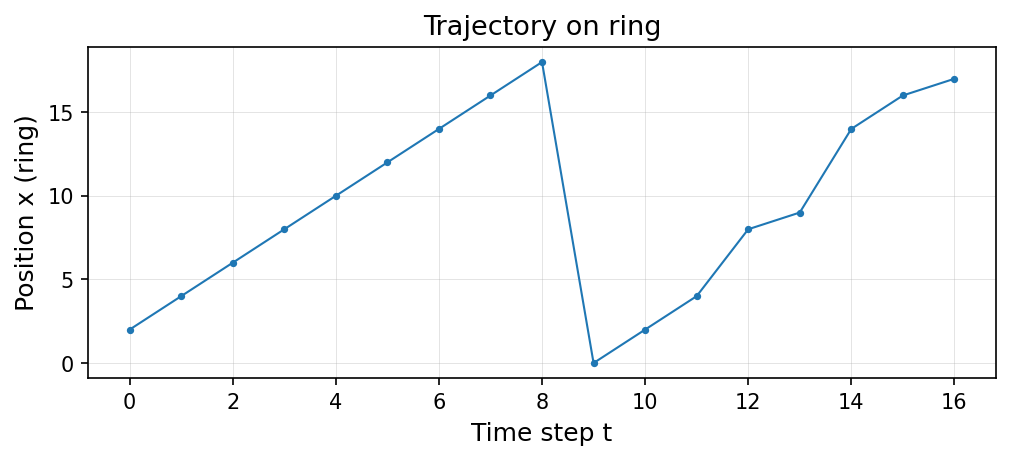

In [34]:
# Plot 1 — Trajectory on ring: position vs time
fig, ax = plt.subplots(figsize=(7.0, 3.2))
ax.plot(df["t"], df["x"], marker="o", markersize=2.5, linewidth=1.0)
ax.set_xlabel("Time step t")
ax.set_ylabel("Position x (ring)")
ax.set_title("Trajectory on ring")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()


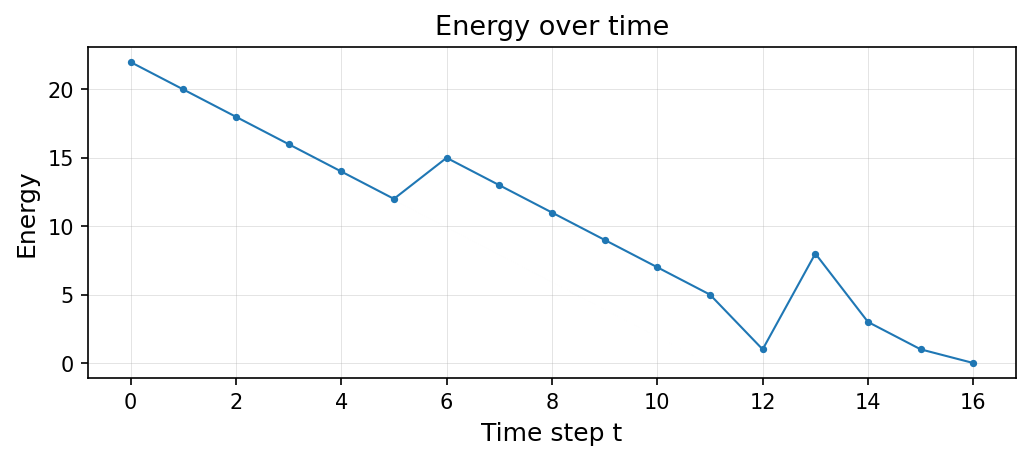

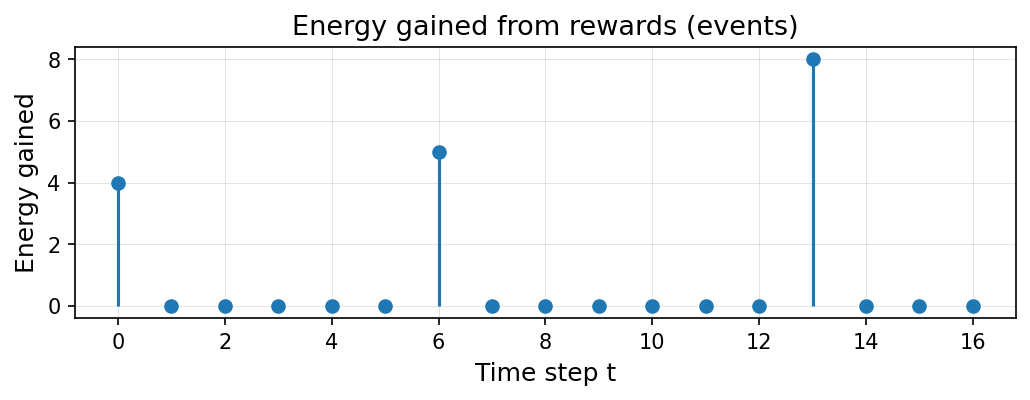

In [35]:
# Plot 2 — Energy over time + recharge events
fig, ax = plt.subplots(figsize=(7.0, 3.2))
ax.plot(df["t"], df["energy"], marker="o", markersize=2.5, linewidth=1.0)
ax.set_xlabel("Time step t")
ax.set_ylabel("Energy")
ax.set_title("Energy over time")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()

# Recharge spikes
if df["energy_gain"].sum() > 0:
    fig, ax = plt.subplots(figsize=(7.0, 2.8))
    ax.stem(df["t"], df["energy_gain"], basefmt=" ")
    ax.set_xlabel("Time step t")
    ax.set_ylabel("Energy gained")
    ax.set_title("Energy gained from rewards (events)")
    ax.grid(True, linewidth=0.4, alpha=0.4)
    fig.tight_layout()
    plt.show()


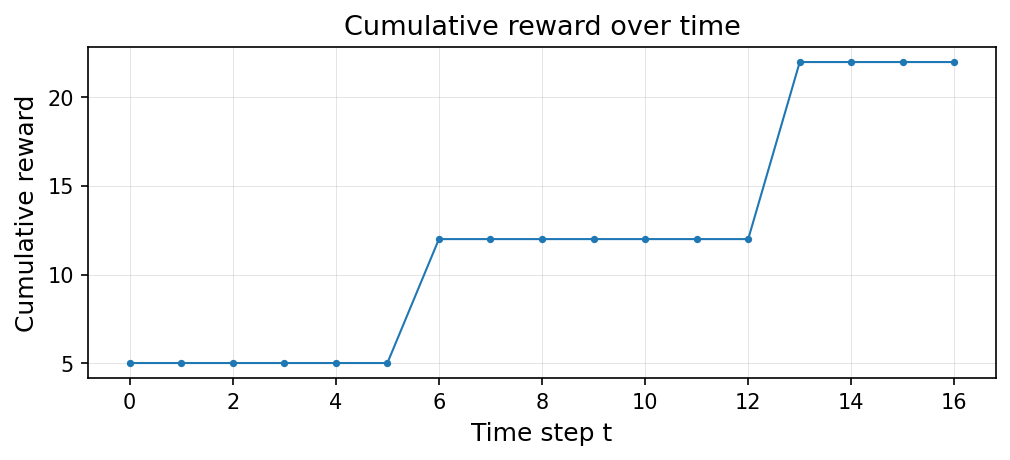

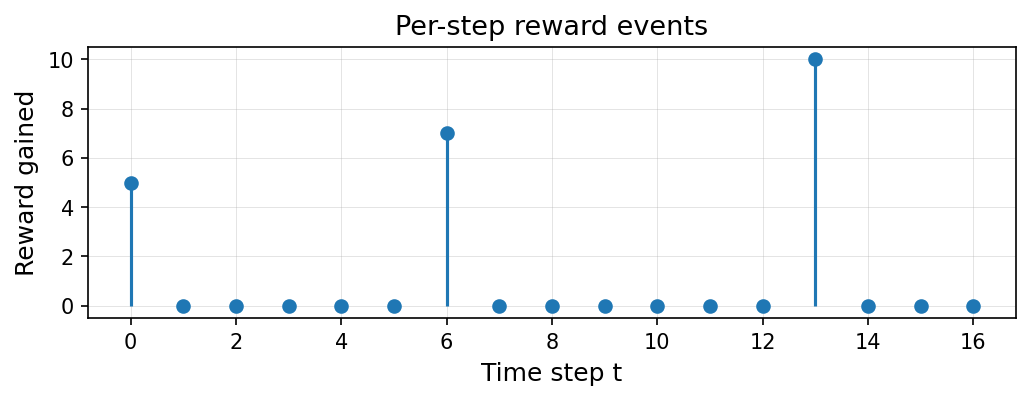

In [36]:
# Plot 3 — Reward dynamics: cumulative reward + per-step events
fig, ax = plt.subplots(figsize=(7.0, 3.2))
ax.plot(df["t"], df["reward_cum"], marker="o", markersize=2.5, linewidth=1.0)
ax.set_xlabel("Time step t")
ax.set_ylabel("Cumulative reward")
ax.set_title("Cumulative reward over time")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7.0, 2.8))
ax.stem(df["t"], df["reward"], basefmt=" ")
ax.set_xlabel("Time step t")
ax.set_ylabel("Reward gained")
ax.set_title("Per-step reward events")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()


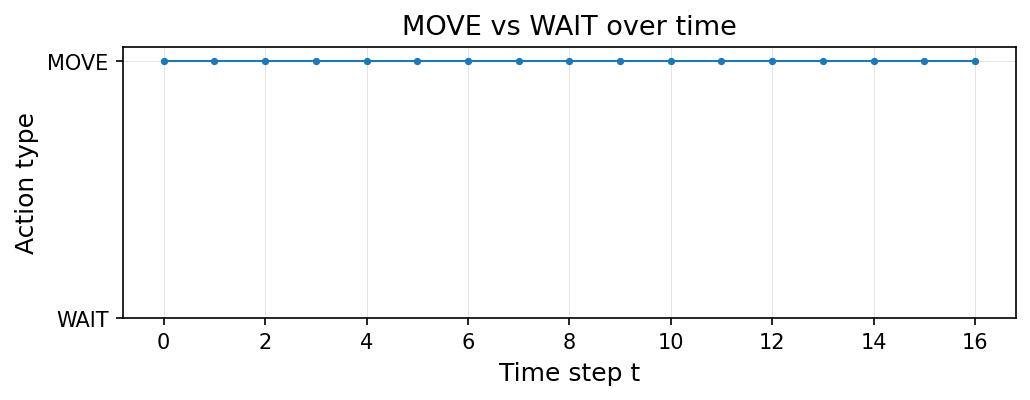

In [37]:
# Plot 4 — MOVE vs WAIT over time
type_map = {"WAIT": 0, "MOVE": 1}
df["move_indicator"] = df["action_type"].map(type_map).fillna(0)

fig, ax = plt.subplots(figsize=(7.0, 2.8))
ax.plot(df["t"], df["move_indicator"], marker="o", markersize=2.5, linewidth=1.0)
ax.set_xlabel("Time step t")
ax.set_ylabel("Action type")
ax.set_yticks([0, 1], ["WAIT", "MOVE"])
ax.set_title("MOVE vs WAIT over time")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()


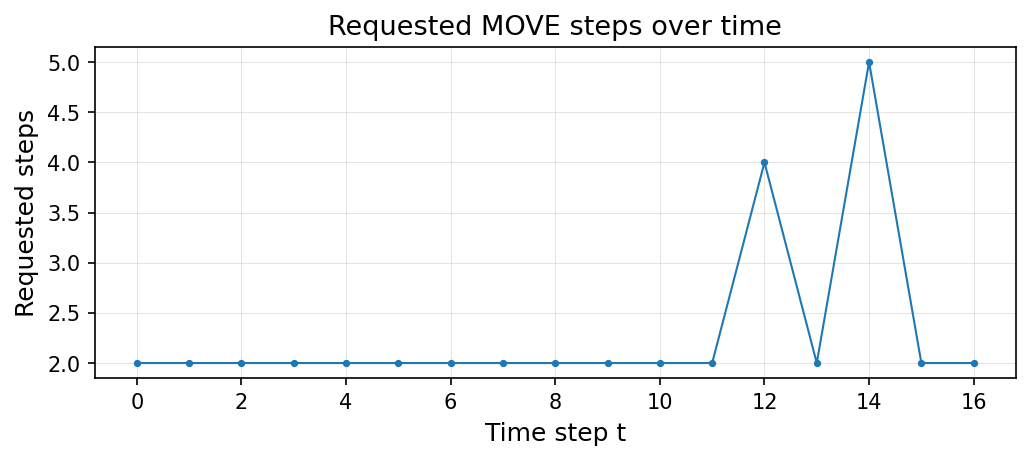

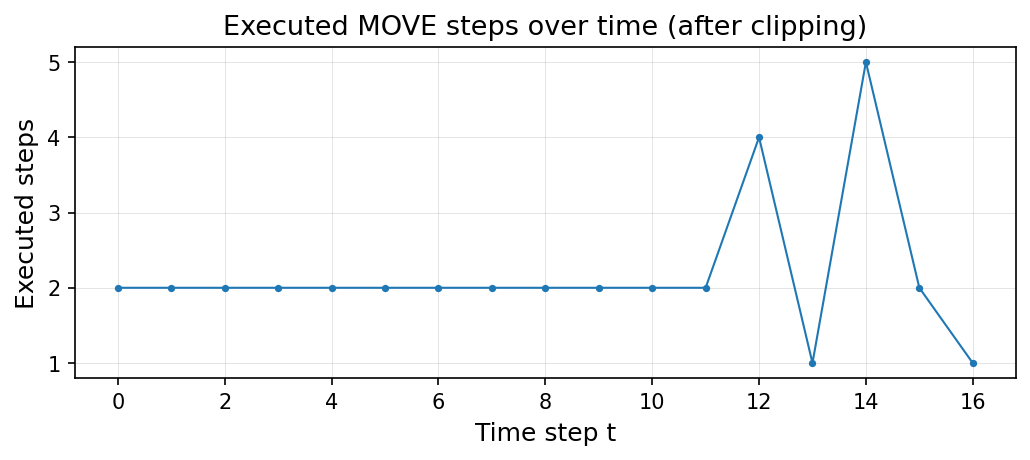

In [38]:
# Plot 5 — Requested steps vs executed steps (clipping visibility)
fig, ax = plt.subplots(figsize=(7.0, 3.2))
ax.plot(df["t"], df["action_steps_req"], marker="o", markersize=2.5, linewidth=1.0)
ax.set_xlabel("Time step t")
ax.set_ylabel("Requested steps")
ax.set_title("Requested MOVE steps over time")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7.0, 3.2))
ax.plot(df["t"], df["steps_executed"], marker="o", markersize=2.5, linewidth=1.0)
ax.set_xlabel("Time step t")
ax.set_ylabel("Executed steps")
ax.set_title("Executed MOVE steps over time (after clipping)")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()


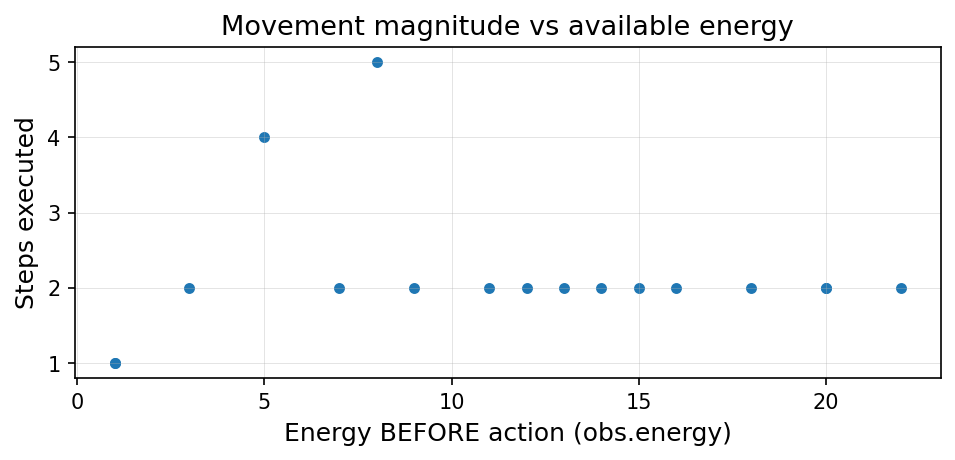

In [39]:
# Plot 6 — Executed steps vs energy (scatter)
# (shows whether agent takes larger moves with more energy)
fig, ax = plt.subplots(figsize=(6.5, 3.2))
ax.scatter(df["obs_energy"], df["steps_executed"], s=18)
ax.set_xlabel("Energy BEFORE action (obs.energy)")
ax.set_ylabel("Steps executed")
ax.set_title("Movement magnitude vs available energy")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()


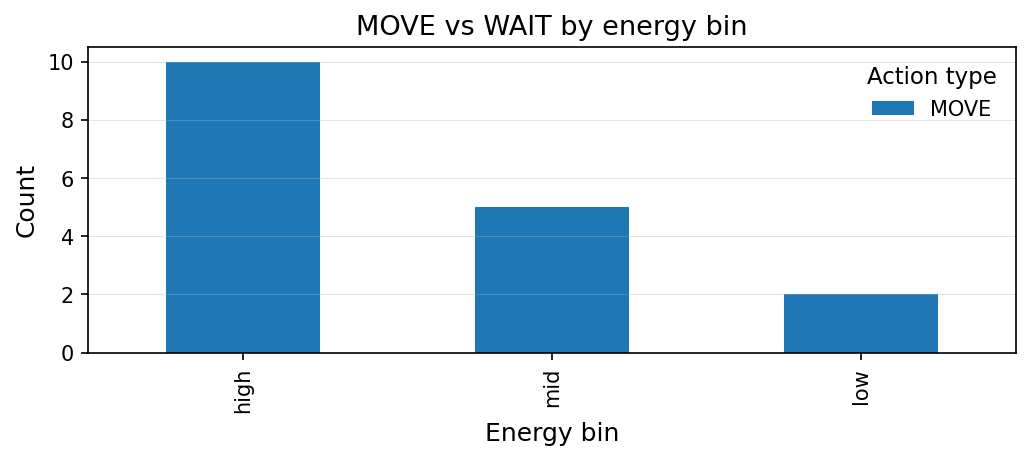

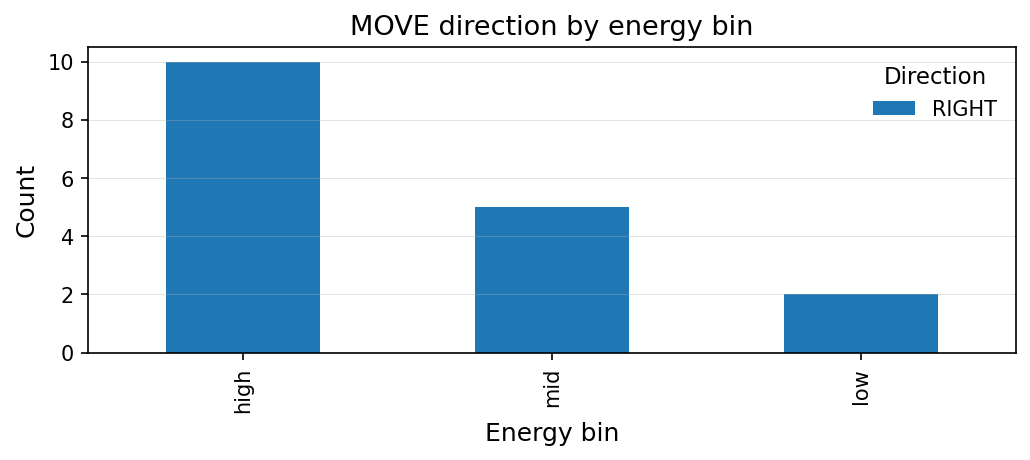

In [40]:
# Plot 7 — Action counts by energy bin (computed from trajectory)
# This is safer than relying on metrics.json keys that may evolve.
df["e_bin"] = df["obs_energy"].apply(energy_bin)

counts_type = (
    df.groupby(["e_bin", "action_type"])
      .size()
      .unstack(fill_value=0)
      .reindex(index=["high", "mid", "low"], fill_value=0)
)

fig, ax = plt.subplots(figsize=(7.0, 3.2))
counts_type.plot(kind="bar", ax=ax)
ax.set_xlabel("Energy bin")
ax.set_ylabel("Count")
ax.set_title("MOVE vs WAIT by energy bin")
ax.grid(True, axis="y", linewidth=0.4, alpha=0.4)
ax.legend(title="Action type", frameon=False)
fig.tight_layout()
plt.show()

# Direction counts for MOVE only
df_move = df[df["action_type"] == "MOVE"].copy()
if len(df_move) > 0:
    counts_dir = (
        df_move.groupby(["e_bin", "action_dir"])
               .size()
               .unstack(fill_value=0)
               .reindex(index=["high", "mid", "low"], fill_value=0)
    )
    fig, ax = plt.subplots(figsize=(7.0, 3.2))
    counts_dir.plot(kind="bar", ax=ax)
    ax.set_xlabel("Energy bin")
    ax.set_ylabel("Count")
    ax.set_title("MOVE direction by energy bin")
    ax.grid(True, axis="y", linewidth=0.4, alpha=0.4)
    ax.legend(title="Direction", frameon=False)
    fig.tight_layout()
    plt.show()


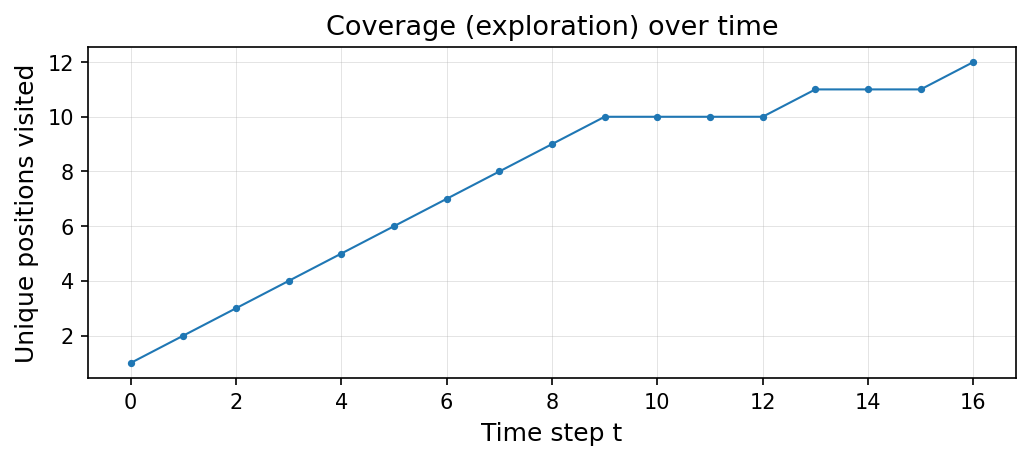

In [41]:
# Plot 8 — Coverage over time (unique positions visited)
visited = set()
coverage = []
for x in df["x"].tolist():
    visited.add(int(x))
    coverage.append(len(visited))

fig, ax = plt.subplots(figsize=(7.0, 3.2))
ax.plot(df["t"], coverage, marker="o", markersize=2.5, linewidth=1.0)
ax.set_xlabel("Time step t")
ax.set_ylabel("Unique positions visited")
ax.set_title("Coverage (exploration) over time")
ax.grid(True, linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()
